![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Copyright:** 2025 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)

<div class="alert alert-block alert-success">
<h3>Destination Earth - HDA Climate DT Parameter Plotter Tutorial</h3></div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li>
<b> References: </b>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li>
<b> Credit: </b>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li>
</div>

This notebook demonstrates how to use the **HDA (Harmonized Data Access)** API to query and access Climate DT data.

A correct combination of parameters is necessary to access DT data for different types of simulations.
The aim of this notebook is to help you create the correct request to access the desired Climate DT data, through HDA, and visualize it.

Below the main steps covered by this tutorial.

1. [Setup](ClimateDT-ParameterPlotter.ipynb#Setup): Import the required libraries and define some function. 
2. [Parameter Selection](ClimateDT-ParameterPlotter.ipynb#Parameter-Selection): How to select the desired Climate DT variable and check its characteristics. 
3. [Simulation Selection](ClimateDT-ParameterPlotter.ipynb#Scenario-Simulation-Selection):  How to select the desired Climate DT variable. 
4. [Levels Selection](ClimateDT-ParameterPlotter.ipynb#Levels-Selection): How to Handle different Levels to be selected (if any).
5. [Order and Download](ClimateDT-ParameterPlotter.ipynb#Order-and-Download): How to order and download Climate DT data.
6. [Plot](ClimateDT-ParameterPlotter.ipynb#EarthKit): How to visualize hourly data on single levels data through Earthkit.


[Documentation DestinE DataLake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Introduction-to-Discovery-and-Data-Access-services/Introduction-to-Discovery-and-Data-Access-services.html#hda-harmonised-data-access)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)





# Setup

Import the Climate DT parameters & scenarios dictionary and all the required packages.

In [1]:
import destinelab as deauth
from destinelab import climate_dt_dictionary
import ipywidgets as widgets
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON

Define some useful funtions to simplify the parameters selection.

In [2]:
#parameters

def filter_entries(search_string):
    return [(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params) if search_string.lower() in entry['paramName'].lower()]

def on_search_change(change):
    search_string = change.new
    if search_string:
        filtered_options = filter_entries(search_string)
        entry_dropdown.options = filtered_options
    else:
        entry_dropdown.options = [(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params)]
        
def get_selected_entry():
    return entry_dropdown.value

#simulations

# Function to generate hourly slots
def generate_hourly_slots():
    hours = []
    for hour in range(0, 24):
        for minute in range(0, 60, 60):  # Step by 60 minutes (1 hour)
            hours.append(datetime.time(hour, minute))
    return hours

def on_scenario_change(change):
    selected_scenario_index, selected_resolution = change.new
    selected_sc_entry = climate_dt_dictionary.climateDT_scenario[selected_scenario_index]
    date_from = datetime.datetime.strptime(selected_sc_entry['dateFrom'], '%m/%d/%Y').date()
    start_date_picker.max = None
    start_date_picker.min = date_from
    start_date_picker.max = datetime.datetime.strptime(selected_sc_entry['dateTo'], '%m/%d/%Y').date()
    start_date_picker.value = date_from
    
def get_selected_values():
    selected_scenario_index, selected_resolution = scenario_dropdown.value
    selected_scenario = climate_dt_dictionary.climateDT_scenario[selected_scenario_index]
    selected_start_date = start_date_picker.value
    selected_end_date = "" # end_date_picker.value
    selected_hour = "00:00:00"
    if selected_entry["time"] == "Hourly":
        selected_hour = hour_dropdown.value
        
    return selected_scenario_index, selected_scenario, selected_resolution, selected_start_date, selected_end_date, selected_hour

# kevels

# Define a global variable
global global_widget
global_widget = None

# Create a function to generate the widget based on the selection mode
def generate_widget(selection_mode):
    global global_widget
    if selection_mode == 'Single':
        global_widget = widgets.Dropdown(options=levelist, description='Select level:')
        return global_widget
    elif selection_mode == 'Multiple':
        global_widget = widgets.SelectMultiple(options=levelist, description='Select levels:')
        return global_widget
    
    
# Function to display the widget based on the selection mode
def display_widget(selection_mode):
    output.clear_output()
    with output:
        display(generate_widget(selection_mode))

# Define a function to handle the change in selection mode
def on_dropdown_change(change):
    display_widget(change.new)
    
# Function to convert tuple or single integer to string separated by "/"
def convert_to_string(input):
    if isinstance(input, tuple):
        return '/'.join(map(str, input))
    elif isinstance(input, int):
        return str(input)
    else:
        return None  # Handle other types if needed


# Parameter Selection

Climate DT variable selection (we limit the plotting to one variable)



In [3]:
text=widgets.Label(value='Start writing the name of the parameter of interest in the search box and/or open the dropdown menu below')

# Create search box
search_box = widgets.Text(placeholder='Search by parameter name', description='Search:', disabled=False)

# Create dropdown to select entry
entry_dropdown = widgets.Dropdown(
    options=[(entry['paramName'], i) for i, entry in enumerate(climate_dt_dictionary.climateDT_params)],
    description='Select Entry:'
)

# handle search box event
search_box.observe(on_search_change, names='value')

# Display widgets
display(text,search_box, entry_dropdown)


Label(value='Start writing the name of the parameter of interest in the search box and/or open the dropdown me…

Text(value='', description='Search:', placeholder='Search by parameter name')

Dropdown(description='Select Entry:', options=(('Total column cloud liquid water', 0), ('Total column cloud ic…

Let's see the  details of the selected parameter (Polytope convention).

From the details it is possible to see the parameter characteristic as the time resolution and the models with which the parameter can be obtained. 

In [4]:
selected_index = get_selected_entry()
selected_entry = climate_dt_dictionary.climateDT_params[selected_index]
print(json.dumps(selected_entry,indent=4))

{
    "param": "167",
    "paramName": "2 metre temperature",
    "shortName": "2t",
    "unit": "K",
    "encoding": "instantaneous",
    "isNemo": "IFS-NEMO",
    "isIcon": "ICON",
    "isFESOM": "IFS-FESOM",
    "stream": "clte",
    "type": "fc",
    "time": "Hourly",
    "levtype": "sfc",
    "levelist": ""
}


# Scenario Simulation Selection
Let's select now the Scenario from which we want to obtain the Climate Parameter

In [5]:
# Create dropdown to select scenario
scenario_dropdown = widgets.Dropdown(
    options=[(f"{entry['experiment']} - {entry['model']} - {resolution}", (i, resolution)) for i, entry in enumerate(climate_dt_dictionary.climateDT_scenario) for resolution in entry['resolution']],
    description='Scenario:'
)

# Create dropdown to select hour
hourly_slots = generate_hourly_slots()
hour_dropdown = widgets.Dropdown(options=[(str(slot), slot) for slot in hourly_slots], description='Select Hour:', disabled=False)

# Create date picker widgets
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False)

# handle dropdown event
scenario_dropdown.observe(on_scenario_change, names='value')

# Set initial values directly
selected_sc_entry = climate_dt_dictionary.climateDT_scenario[0]

# Convert dateFrom string to date object
date_from = datetime.datetime.strptime(selected_sc_entry['dateFrom'], '%m/%d/%Y').date()

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = datetime.datetime.strptime(selected_sc_entry['dateTo'], '%m/%d/%Y').date()
start_date_picker.value = date_from

# Display widgets
if selected_entry["time"] == "Hourly":
    display(scenario_dropdown, start_date_picker, hour_dropdown)
else:
    display(scenario_dropdown, start_date_picker)


Dropdown(description='Scenario:', options=(('ssp3-7.0 - IFS-NEMO - high', (0, 'high')), ('ssp3-7.0 - IFS-NEMO …

DatePicker(value=datetime.date(2020, 1, 1), description='Start Date:', max=datetime.date(2039, 12, 30), min=da…

Dropdown(description='Select Hour:', options=(('00:00:00', datetime.time(0, 0)), ('01:00:00', datetime.time(1,…

In [6]:
selected_scenario_index, selected_scenario, selected_resolution, selected_start_date, selected_end_date, selected_hour = get_selected_values()

# Levels Selection
Handle different Levels to be selected (if any)

In [7]:
if selected_entry["levelist"] != "":
    # Convert levelist string to list of integers
    levelist = list(map(int, selected_entry["levelist"].split('/')))
    if(selected_scenario['model']=='IFS-NEMO'):
        levelist = levelist + [73,74,75]

    # Create a dropdown widget to choose selection mode
    selection_mode_dropdown = widgets.Dropdown(options=['Single', 'Multiple'], description='Selection Mode:')

    # Create an output widget to display the selected option(s)
    output = widgets.Output()

    # Register the function to handle dropdown changes
    selection_mode_dropdown.observe(on_dropdown_change, names='value')

    # Display the widgets
    display(selection_mode_dropdown, output)

    # Display the initial widget based on default selection mode
    display_widget('Single')

# Order and Download

## Obtain Authentication Token

To perform our request we need to be authenticated. 
Below to request of an authentication token.

In [8]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [9]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.
And another one with the ID of the Cliamte DT collection.

In [10]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"

## Convert selected parameters, simulation and levels into HDA request
Convert levels (if any)

In [11]:
levlInput = ""
if global_widget != None:
    # Test cases
    levlInput = convert_to_string(global_widget.value)

Convert the chosen parameters into an HDA request for Climate DT data and print the created filters.

In [12]:
hourchoice4 = '{shour}00'.format(shour = str(get_selected_values()[5]).split(":")[0])

filter_params = {
  "ecmwf:class" : get_selected_values()[1] .get("class","d1"),
  "ecmwf:dataset": "climate-dt",   # fixed climate-dt access
  "ecmwf:activity" : get_selected_values()[1]["activity"],
  "ecmwf:experiment" : get_selected_values()[1]["experiment"].upper(),
  "ecmwf:model": get_selected_values()[1]["model"],
  "ecmwf:generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
  "ecmwf:resolution": get_selected_values()[2],      # standard/ high 
  "ecmwf:expver": "0001",          # fixed experiment version 
  "ecmwf:stream": selected_entry["stream"],
  "ecmwf:time": hourchoice4,            # choose the hourly slot(s)
  "ecmwf:type": "fc",              # fixed forecasted fields
  "ecmwf:levtype": selected_entry["levtype"],  
  "ecmwf:levelist": str(levlInput),  
  "ecmwf:param": str(selected_entry["param"]),
  "ecmwf:realization":get_selected_values()[1] .get("realization", "1")
}

# Print the result in JSON format
datechoice = "{fname}T{shour}Z".format(fname = get_selected_values()[3], shour = get_selected_values()[5] )
print("datechoice = ", datechoice)

# Check if levelist is empty and remove it
if filter_params.get("ecmwf:levelist") == "":
    del filter_params["ecmwf:levelist"]

if selected_entry["time"] == "Daily":
    del filter_params["ecmwf:time"]

hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}

print(json.dumps(hdaFilters, indent=4))

datechoice =  2028-06-06T00:00:00Z
{
    "ecmwf:class": {
        "eq": "d1"
    },
    "ecmwf:dataset": {
        "eq": "climate-dt"
    },
    "ecmwf:activity": {
        "eq": "ScenarioMIP"
    },
    "ecmwf:experiment": {
        "eq": "SSP3-7.0"
    },
    "ecmwf:model": {
        "eq": "IFS-NEMO"
    },
    "ecmwf:generation": {
        "eq": "1"
    },
    "ecmwf:resolution": {
        "eq": "high"
    },
    "ecmwf:expver": {
        "eq": "0001"
    },
    "ecmwf:stream": {
        "eq": "clte"
    },
    "ecmwf:time": {
        "eq": "0000"
    },
    "ecmwf:type": {
        "eq": "fc"
    },
    "ecmwf:levtype": {
        "eq": "sfc"
    },
    "ecmwf:param": {
        "eq": "167"
    },
    "ecmwf:realization": {
        "eq": "1"
    }
}


### Filtering

Search into asynchronous datasets, as the DTs are, always return a single item:

In [23]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = session.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
    "datetime": datechoice,
    "query": hdaFilters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

The single item returned (above) contains:
- The product id: "DT_CLIMATE_ADAPTATION_ORDERABLE_...", that is a placeholder, its name contains the term "ORDERABLE".
- The storage:tier that indicates that the product is "offline"
- The order:status that indicates that the product is "orderable"
- Request params used for the order extracted from the search result

In [ ]:
ecmwf_properties = {
    key: value for key, value in product.get('properties', {}).items()
    if key.startswith('ecmwf:')
}

## Order data

We have now all the information to order the data.

From the search results we know that the product is orderable and offline, we then need to order the product we searched for.

In [18]:
response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=ecmwf_properties, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")    

Product ordered: 07735148-ddc3-4017-a8a9-34980588c3f6
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping


### Poll the API until product is ready

We request the product itself to get an update of its status.

In [19]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    


Polling 1/300
Product is ready to be downloaded.
Asset URL: https://hda-download.central.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/07735148-ddc3-4017-a8a9-34980588c3f6/downloadLink


# Download

In [20]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 07735148-ddc3-4017-a8a9-34980588c3f6.grib


26.2MB [00:00, 56.4MB/s]


## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html) selecting only the Europe area in the plot.

In [21]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

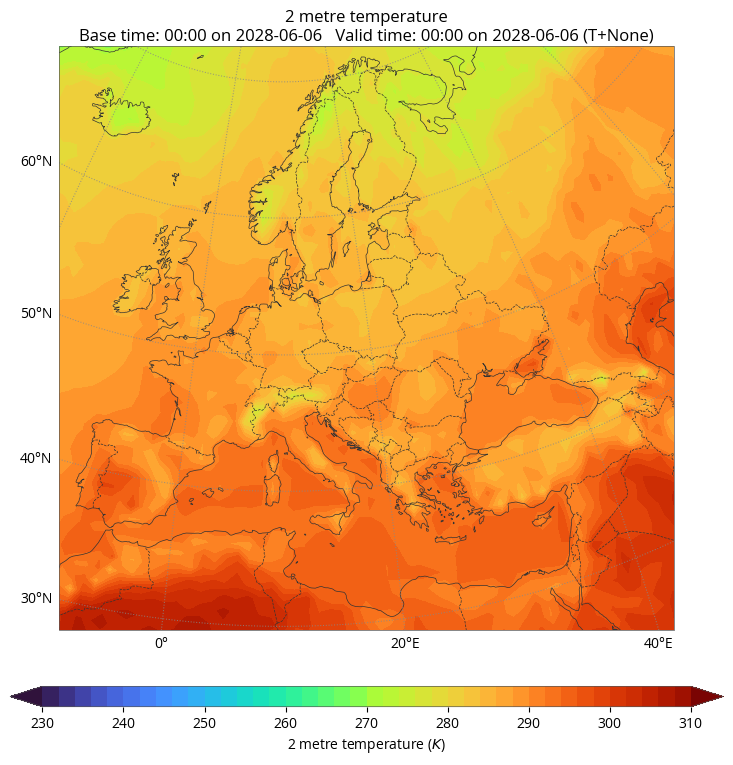

In [22]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data,domain="Europe")

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)